# **Bias measuring and mitigation in multiclassification tasks**

With the increasing use of machine learning models in different areas, it has become important to address the bias problem in these models. This issue can appear in different aspects such as racial, gender or socioeconomic biases leading to unfair outcomes in decision-making processes, for instance, in classification tasks, where models are trained to classify data into different categories.

There are various techniques to measure bias in classification models such as Equalized Odds, Statistical or Demographic Parity or Opportunity Equality for instance, which quantify the differences in the model's performance across different subgroups based on sensitive attributes such as gender or race.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in multi-classification models.

We will follow the traditional outline for this tutorial:

1. Data loading and packages installation
2. Dataset preprocessing
3. Data analysis
4. Model training
5. Bias measuring
6. Bias mitigation
7. Results comparison

## **1. Data loading and packages installation**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai
```

Next, we need to import all the required packages that we will use along this tutorial:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Settings
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

## **2. Dataset preprocessing**

The dataset that we will use is the "Communities and Crime" dataset which is a publicly available dataset that contains socio-economic and law enforcement data for 1994 communities in the United States. This dataset contains demographic variables such as population size, race, and education level, as well as variables related to law enforcement. Although this dataset is widely used for regression analysis, in this opportunity we will slightly transform the output to use it in a multi-class task. Then, the objective is to predict the crime rate per capita in each community according the assigned class.

Source: [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/communities+and+crime)

In [3]:
from holisticai.datasets import load_dataset

To speed up the process, the `load_dataset` function of the *holisticai* package allows to return the raw dataset or the preprocessed dataset by setting the `preprocess` parameter to `True`. This function also allows to return the dataset and the protected as a pandas dataframe or as a numpy array. You will find more information about the target and the protected groups of this function in its documentation.

In this tutorial, we will use the preprocessed dataset as a pandas dataframe.

In [4]:
df, group_a, group_b = load_dataset(dataset='crime', preprocessed=True, as_array=False)

In [5]:
df.isna().sum()

population             0
householdsize          0
numbUrban              0
pctUrban               0
medIncome              0
                      ..
LandArea               0
PopDens                0
PctUsePubTrans         0
LemasPctOfficDrugUn    0
ViolentCrimesPerPop    0
Length: 93, dtype: int64

Now, we will transform the target column in order to have a multiclass column, to do that we will define the following function:

In [6]:
def convert_float_to_categorical(target, nb_classes, numeric_classes=True):
    eps = np.finfo(float).eps
    if numeric_classes:
        labels = list(range(nb_classes))
    else:
        labels = [f"Q{c}-Q{c+1}" for c in range(nb_classes)]
    labels_values = np.linspace(0, 1, nb_classes + 1)
    v = np.array(target.quantile(labels_values)).squeeze()
    v[0], v[-1] = v[0] - eps, v[-1] + eps
    y = target.copy()
    for (i, c) in enumerate(labels):
        y[(target.values >= v[i]) & (target.values < v[i + 1])] = c
    return y.astype(np.int32)

In [7]:
nb_classes = 5

X = df.iloc[:, :-1]
y = convert_float_to_categorical(df.iloc[:, -1], nb_classes=nb_classes)

## **3. Data analysis**

Once the dataset have been preprocessed we can perform some analysis into the sex and race features in order to define the protected attribute. The `holisticai` library possesses some useful plotting tools that we can use, for example the `group_pie_plot` function that allows us to observe the proportions of the categories of the instances in a certain feature:

<Axes: >

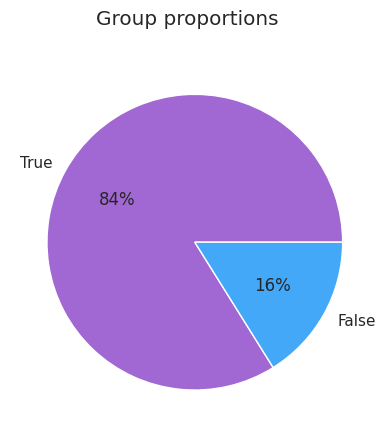

In [8]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(group_a)

<AxesSubplot:>

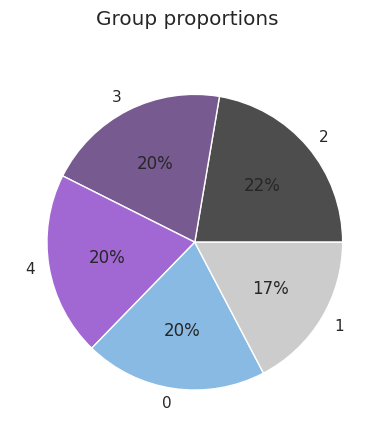

In [13]:
group_pie_plot(y)

The previous graphs show us that the proportion of white people is high compared to the remain, and the target disctribution is almost the same for all the classes. Now, we will define our training and testing sets:

In [9]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

## **4. Model training**

Once we have defined the training and testing sets, we can train a model as usual. Since the protected groups were separated from the dataset previously we do not need to take care of that in this opportunity, but do not forget to separate the protected attributes from the dataset, so that the model does not have any influence from these attributes in its training process. 

For the training, we will start with the traditional pipeline, we will fit and re-scale the training data, and then we will train a "Logistic regression" model. Once the model has been trained, we will use its predictions to measure the bias present on the model with respect to the protected groups defined previoulsy.

In [10]:
from holisticai.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from holisticai.utils.transformers.bias import SensitiveGroups

In [11]:
# efficacy metrics from sklearn
from sklearn import metrics

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")

In [12]:
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

LR = LogisticRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data
X = scaler.transform(X)

y_pred = model.predict(X)

In [13]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.466165
Balanced accuracy,0.459036


## **5. Bias measuring**

The fairness of the model can be calculated using the predictions of the model and the protected groups defined previously. The `holisticai` contains a module that calculates a set of metrics useful in evaluating the fairness of algorithmic decisions. For our case, we will use the `multiclass_bias_metrics` function which allows us to select which metrics we want to calculate, if `equal_outcome`, `equal_opportunity` or `both`, where equal_outcome shows how disadvantaged groups are treated by the model and equal_opportunity shows if all the groups have the same opportunities.

In [14]:
from holisticai.bias.metrics import multiclass_bias_metrics
sensgroup = SensitiveGroups()

In [15]:
p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_baseline = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_baseline

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.642819,0
Mean Multiclass Statistical Parity,0.642819,0
Max Multiclass Equality of Opportunity,0.491702,0
Max Multiclass Average Odds,0.402064,0
Max Multiclass True Positive Difference,0.315663,0
Mean Multiclass Equality of Opportunity,0.491702,0
Mean Multiclass Average Odds,0.402064,0
Mean Multiclass True Positive Difference,0.315663,0


All of the previous metrics are generalizations of the metris used for the binary case, consequently:

*   **Multiclass Statistical parity:** Computes the statistical parity between multiple classes and a protected attribute with multiple groups. For each group computes the vector of success rates for entering each class, finally uses the mean or max strategies to aggregate them. Same as the 1d case, values in the range (-0.1, 0.1) are considered acceptable.
*   **Multiclass Equality of Opportunity:** Computes the matrix of error rates for each group, then computes all distances (mean absolute deviation) between such matrices, finally uses the mean or max strategies to aggregate them. Same as the 1d case, values in the range (-0.1, 0.1) are considered acceptable.
*   **Multiclass Average Odds:** Computes the matrix of error rates for each group, then averages these matrices over rows, and computes all pairwise distances between the resulting vectors, finally uses the mean or max strategies to aggregate them. Same as the 1d case, values in the range (-0.1, 0.1) are considered acceptable.
*   **Multiclass True Positive Difference:** Computes the matrix of error rates for each group, then computes all pairwise distances between the diagonal of such matrices, finally uses the mean or max strategies to aggregate them. Same as the 1d case, values in the range (-0.1, 0.1) are considered acceptable.


Source: [*HolisticAI docs*](https://holisticai.readthedocs.io/en/latest/metrics.html#multiclass-classification)

## **6. Bias mitigation**
### **Correlation remover: Preprocessing method**

Now that we could observe that the model metrics are far away from the desired values, we need to apply some kind of strategy to mitigate the bias present in the model.

Exists different kinds of strategies, and the literature has divided them into three categories: *Pre-processing*, *in-processing* and *post-processing* methods. The `holisticai` library possesses different algorithms from these categories for bias mitigation. An interesting feature is that all of them are compatible with the `Scikit-learn` package, so that, if you are familiar with this package, you will not have problems using the library. As you will see later, its implementation can be done following the traditional way, or by applying the pipeline. 

For this opportunity, we will implement the "Correlation remover" method which is a pre-processing technique that applies a linear transformation to the non-sensitive features of the dataset to remove the correlation with respect to the sensitive columns. This process is done aiming to maintain as much as possible to prevent lost information.

### **Traditional implementation**

In [16]:
from holisticai.bias.mitigation import CorrelationRemover

In [17]:
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = CorrelationRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_corr_rem = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.422266,0
Mean Multiclass Statistical Parity,0.422266,0
Max Multiclass Equality of Opportunity,0.425937,0
Max Multiclass Average Odds,0.251931,0
Max Multiclass True Positive Difference,0.363020,0
Mean Multiclass Equality of Opportunity,0.425937,0
Mean Multiclass Average Odds,0.251931,0
Mean Multiclass True Positive Difference,0.363020,0


### **Pipeline implementation**

Now that we could see how this method is implemented traditionally, let's try implementing it by using the Scikit-learn Pipeline. Notice that we shouldn't have highly variations in the metrics for the previous implementation.

In [18]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", LogisticRegression()),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a, 
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)

p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_corr_rem_w_p = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem_w_p

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.422266,0
Mean Multiclass Statistical Parity,0.422266,0
Max Multiclass Equality of Opportunity,0.425937,0
Max Multiclass Average Odds,0.251931,0
Max Multiclass True Positive Difference,0.363020,0
Mean Multiclass Equality of Opportunity,0.425937,0
Mean Multiclass Average Odds,0.251931,0
Mean Multiclass True Positive Difference,0.363020,0


## **7. Results comparison**

Now that we could observe how is the implementation of the mitigator in the model, we will compare the results between the baseline and the implementations with the mitigator to analyse how the metrics have changed.

In [19]:
result = pd.concat([df_baseline, df_corr_rem, df_corr_rem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Max Multiclass Statistical Parity,0.642819,0.422266,0.422266,0
Mean Multiclass Statistical Parity,0.642819,0.422266,0.422266,0
Max Multiclass Equality of Opportunity,0.491702,0.425937,0.425937,0
Max Multiclass Average Odds,0.402064,0.251931,0.251931,0
Max Multiclass True Positive Difference,0.315663,0.363020,0.363020,0
Mean Multiclass Equality of Opportunity,0.491702,0.425937,0.425937,0
Mean Multiclass Average Odds,0.402064,0.251931,0.251931,0
Mean Multiclass True Positive Difference,0.315663,0.363020,0.363020,0


From the previous chart, we can see that although the actual metrics are still far from the ideal values, an improvement is obtained by applying this method in the dataset, compared with our baseline. 

Notice that we can analyse how these values are affected by varying the hyperparameter of the method. For example, this method allows us to set an `alpha` parameter that controls how much information will be filtered, you will find more information in its documentation [here](https://holisticai.readthedocs.io/en/latest/.generated/holisticai.bias.mitigation.CorrelationRemover.html#holisticai.bias.mitigation.CorrelationRemover)

To observe the influence of this variation we will try with different values:

In [ ]:
def calculate_metrics(train_data, test_data, alpha, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", CorrelationRemover(alpha=alpha)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a, 
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

  df = multiclass_bias_metrics(
      p_attr,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      alpha, 
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics

In [ ]:
metrics_val = []
metrics_cols = ['Max Multiclass Statistical Parity', 'Max Multiclass Equality of Opportunity']

for alphas in np.linspace(0,1.5,12):
  metrics_val.append(calculate_metrics(train_data, test_data, alphas, metrics_cols))

metrics = ['alpha', 'accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,alpha,accuracy,Max Multiclass Statistical Parity,Max Multiclass Equality of Opportunity
0,0.000000,0.466165,0.642819,0.491702
1,0.136364,0.473684,0.628327,0.478287
2,0.272727,0.466165,0.564822,0.430314
3,0.409091,0.458647,0.535837,0.406645
4,0.545455,0.446115,0.517128,0.400953
5,0.681818,0.443609,0.480237,0.398133
6,0.818182,0.443609,0.466930,0.402289
7,0.954545,0.438596,0.436759,0.399072
8,1.090909,0.433584,0.411067,0.424333
9,1.227273,0.431078,0.399605,0.420964


Text(0.5, 0, 'alpha')

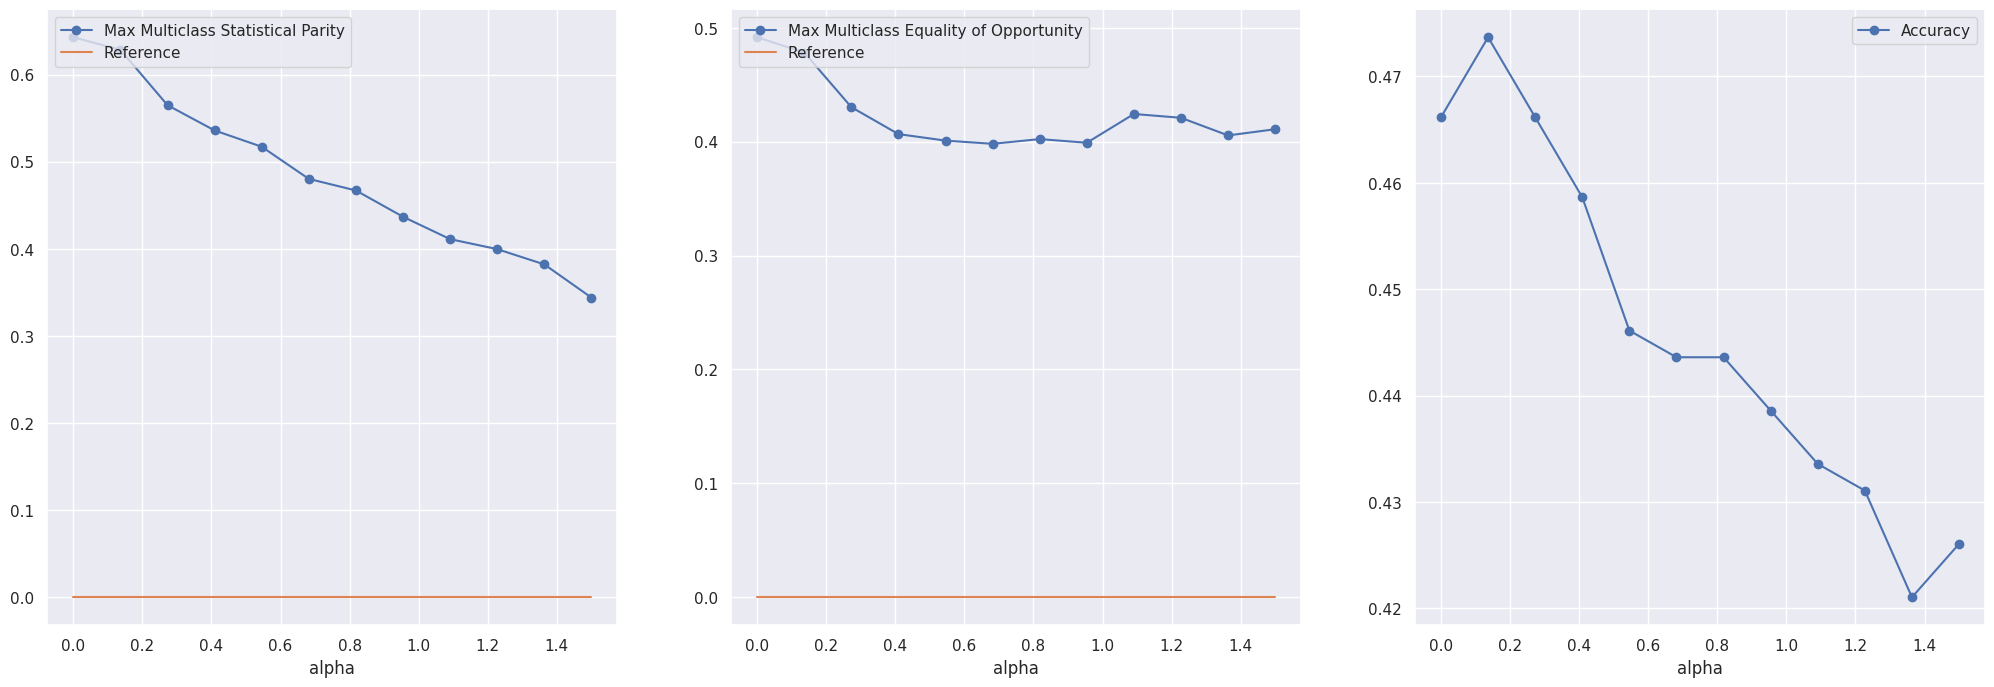

In [ ]:
x_axis = df_metrics.alpha
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Max Multiclass Statistical Parity'], 'o-', label='Max Multiclass Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Max Multiclass Equality of Opportunity'], 'o-', label='Max Multiclass Equality of Opportunity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Equality of Opportunity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(133)
plt.plot(x_axis, df_metrics['accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('alpha')

As we can see, the variation of this parameter shows that when we increase its value the results are closer to the reference, but we need into account that the higher the value of the parameter is, the more information will be filtered but the accuracy will be also affected. In general, the selection of the model parameters will depend on our main objective, whether we are looking for fairness or accuracy.

## **Summary**
Through this tutorial we could present to the user how the `holisticai` library can be easily used to measure the bias present in classification models by the application of the `multiclass_bias_metrics` function, which returns the calculated values for different metrics and their references respectively. 

In addition, we shown how to mitigate the bias by applying some methods, for this opportunity we applied the "Correlation remover" technique to train a fairness model by pre-processing the original dataset through the remotion of the correlation of the features with repect to the sensitive values. Consequently we could observe how the metrics are influenced by varing the `alpha` parameter, and showing how this method increases the fairness of the model.